In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import trange
import torch.nn as nn
import torch.nn.functional as F
from lion_pytorch import Lion

/home/estsoft/miniconda3/envs/MathAI/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("data/final.csv")

data['YearMonth'] = pd.to_datetime(data['YearMonth'])
data.set_index('YearMonth', inplace=True)
data.head()

,Temperature
YearMonth,
1880-01-01,-0.36
1880-02-01,-0.51
1880-03-01,-0.23
1880-04-01,-0.30
1880-05-01,-0.06


# 1.전체를 처음부터 외워서 다음을 맞추기


<Axes: xlabel='YearMonth'>

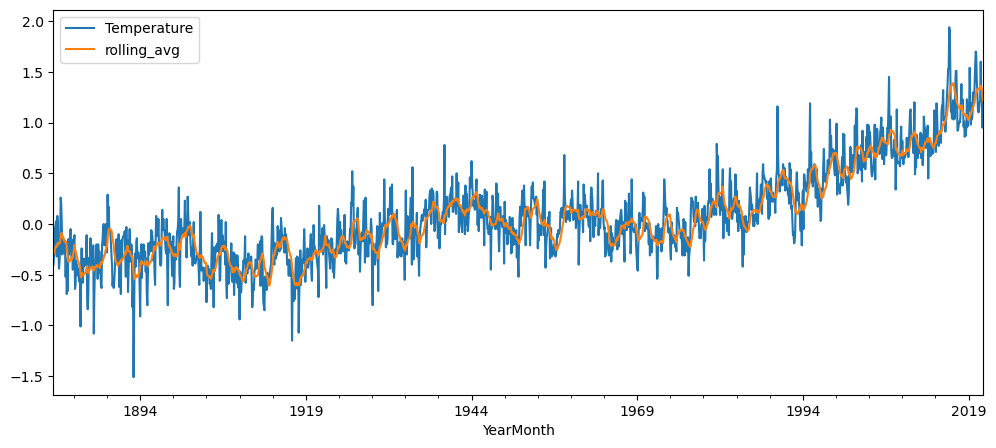

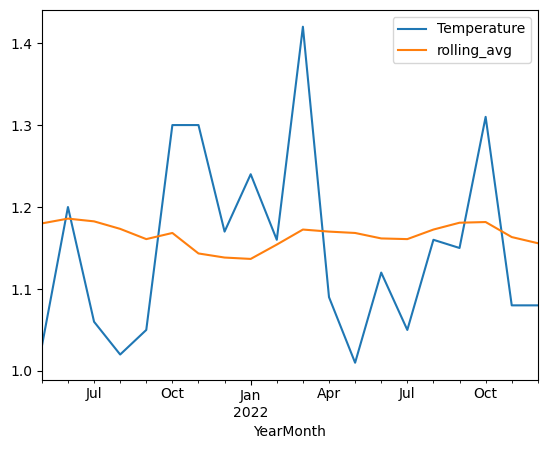

In [3]:
tst_size = 20

data_mw = data.copy()
data_mw['rolling_avg'] = data.Temperature.rolling(12).mean()
data_mw = data_mw.dropna()

trn, tst = data_mw[:-tst_size], data_mw[-tst_size:]

scaler = MinMaxScaler()
scaler_ra = MinMaxScaler()

trn_scaled, tst_scaled = trn.copy(), tst.copy()

trn_scaled['Temperature'] = scaler.fit_transform(trn.Temperature.to_numpy(np.float32).reshape(-1,1))
trn_scaled['rolling_avg'] = scaler_ra.fit_transform(trn.rolling_avg.to_numpy(np.float32).reshape(-1,1))

tst_scaled['Temperature'] = scaler.transform(tst.Temperature.to_numpy(np.float32).reshape(-1,1))
tst_scaled['rolling_avg'] = scaler_ra.transform(tst.rolling_avg.to_numpy(np.float32).reshape(-1,1))

trn_scaled = trn_scaled.to_numpy(np.float32)
tst_scaled = tst_scaled.to_numpy(np.float32)

ax = trn.plot(figsize=(12,5))
tst.plot()

In [4]:
class StatefulLSTM(nn.Module):
  # num_layers 출력하는 값의 수, hidden_size 변경 가능
  def __init__(self, input_size, hidden_size, output_size, num_layers):
    super().__init__()
    self.reset_state()
    self.rnn = nn.LSTM(input_size, hidden_size, num_layers)
    self.head = nn.Linear(hidden_size, output_size)

  def reset_state(self, state=None):
    self.state = state

  def forward(self, x):
    assert x.dim() == 2   # (sequence_length, input_size)
    if self.state is None:
      x, (hn, cn) = self.rnn(x)   # state will be set to be zeros by default
    else:
      x, (hn, cn) = self.rnn(x, self.state)   # pass the saved state
    # x.shape == (sequence_length, hidden_size)
    self.state = (hn.detach(), cn.detach())   # save the state
    x = self.head(x)  # (sequence_length, output_size)
    return F.sigmoid(x)

  def predict(self, x0, steps, state=None):
    if state is not None:
      self.reset_state(state)
    output = []
    x = x0.reshape(1,-1)
    for i in range(steps):
      x = self.forward(x)
      output.append(x)
    return torch.concat(output, 0)

In [5]:
batch_size = 128
trn_x = torch.tensor(trn_scaled[:-1]).split(batch_size)
trn_y = torch.tensor(trn_scaled[1:]).split(batch_size)

tst_y = torch.tensor(tst_scaled)

trn_x[0].shape, trn_y[0].shape

(torch.Size([128, 2]), torch.Size([128, 2]))

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#rnn = StatefulLSTM(2, 32, 2, 1)
rnn = StatefulLSTM(2, 64, 2, 1)
rnn.to(device)

optim = torch.optim.AdamW(rnn.parameters(), lr=0.001)

pbar = trange(1000)
for e in pbar:
  rnn.train()
  rnn.reset_state()
  trn_loss = .0
  for x, y in zip(trn_x, trn_y):
    x, y = x.to(device), y.to(device)
    optim.zero_grad()
    p = rnn(x)
    loss = F.mse_loss(p, y)
    loss.backward()
    optim.step()
    trn_loss += loss.item()
  trn_loss /= len(trn)-1

  rnn.eval()
  with torch.inference_mode():
    p = rnn.predict(y[-1:].to(device), len(tst_y))
    tst_loss = F.mse_loss(p, tst_y.to(device)).item()
  pbar.set_postfix({'trn_loss': trn_loss, 'tst_loss': tst_loss})

100%|██████████| 1000/1000 [00:27<00:00, 36.23it/s, trn_loss=1.11e-5, tst_loss=0.000734]


In [7]:
def cal_mape(y_pred, y_true):
  return (np.abs(y_pred - y_true)/y_true).mean() * 100

def cal_mae(y_pred, y_true):
  return np.abs(y_pred - y_true).mean()

def cal_r2_score(y_pred, y_true):
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    ss_res = np.sum((y_true - y_pred)**2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

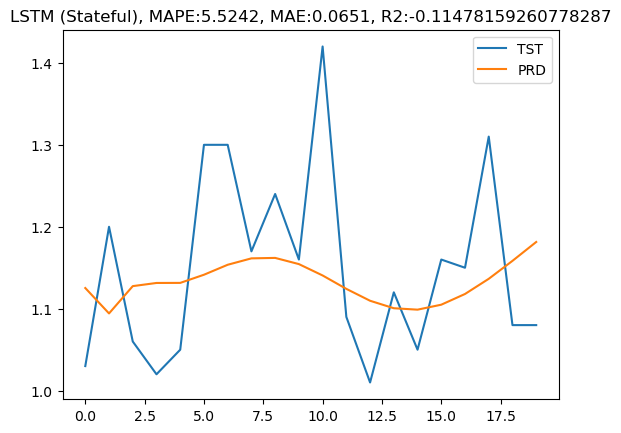

In [8]:
prd = scaler.inverse_transform(p.cpu()[:,:1])

plt.title(f"LSTM (Stateful), MAPE:{cal_mape(prd,tst.to_numpy()):.4f}, MAE:{cal_mae(prd,tst.to_numpy()):.4f}, R2:{cal_r2_score(prd,tst.to_numpy())}")
plt.plot(tst.Temperature.to_numpy(), label='TST')
plt.plot(prd, label='PRD')
plt.legend()
plt.show()

# 2.Look-back Window

In [9]:
class TimeSeriesDataset(torch.utils.data.Dataset):
  def __init__(self, ts:np.array, lookback_size:int, shift_size:int):
    self.lookback_size = lookback_size
    self.shift_size = shift_size
    self.data = ts

  def __len__(self):
    return len(self.data) - self.lookback_size - self.shift_size + 1

  def __getitem__(self, i):
    idx = (i+self.lookback_size)
    look_back = self.data[i:idx]
    forecast = self.data[i+self.shift_size:idx+self.shift_size]

    return look_back, forecast

In [10]:
window_size = 64

trn_ds = TimeSeriesDataset(trn_scaled, window_size, 1)
tst_ds = TimeSeriesDataset(np.concatenate([trn_scaled[-window_size:], tst_scaled], axis=0), window_size, 1)

trn_dl = torch.utils.data.DataLoader(trn_ds, batch_size=64, shuffle=True)
tst_dl = torch.utils.data.DataLoader(tst_ds, batch_size=len(tst_ds), shuffle=False)

In [11]:
x, y = next(iter(trn_dl))
x.shape, y.shape

(torch.Size([64, 64, 2]), torch.Size([64, 64, 2]))

In [12]:
class StatelessLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers):
    super().__init__()
    self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.head = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x, _ = self.rnn(x)   # state will be set to be zeros by default
    # x.shape == (batch_size, sequence_length, hidden_size)
    x = self.head(x)  # (batch_size, sequence_length, output_size)
    return F.sigmoid(x)

  def predict(self, x, steps, state=None):
    output = []
    for i in range(steps):
      x = self.forward(x)
      output.append(x[-1:])
    return torch.concat(output, 0)

In [13]:
rnn = StatelessLSTM(2, 32, 2, 2)
# rnn = StatelessLSTM(2, 64, 2, 2)
rnn.to(device)

x, y = next(iter(tst_dl))
rnn.predict(x[0].to(device), 20).shape

torch.Size([20, 2])

In [14]:
rnn = StatelessLSTM(2, 32, 2, 2)
# rnn = StatelessLSTM(2, 64, 2, 2)
rnn.to(device)

# optim = torch.optim.AdamW(rnn.parameters(), lr=0.001)
optim = torch.optim.Adam(rnn.parameters(), lr=0.0001)
# optim = Lion(rnn.parameters(), lr=0.0001)

pbar = trange(3000)
for e in pbar:
  rnn.train()
  trn_loss = .0
  for x, y in trn_dl:
    x, y = x.to(device), y.to(device)
    optim.zero_grad()
    p = rnn(x)
    loss = F.mse_loss(p, y)
    loss.backward()
    optim.step()
    trn_loss += loss.item()
  trn_loss /= len(trn)-1

  rnn.eval()
  with torch.inference_mode():
    x, y = next(iter(tst_dl))
    p = rnn.predict(x[0].to(device), len(tst_scaled))[:,:1]
    tst_loss = F.mse_loss(p, torch.tensor(tst_scaled[:,:1]).view(-1,1).to(device)).item()
  pbar.set_postfix({'trn_loss': trn_loss, 'tst_loss': tst_loss})

100%|██████████| 3000/3000 [04:10<00:00, 11.96it/s, trn_loss=1.46e-5, tst_loss=0.00548] 


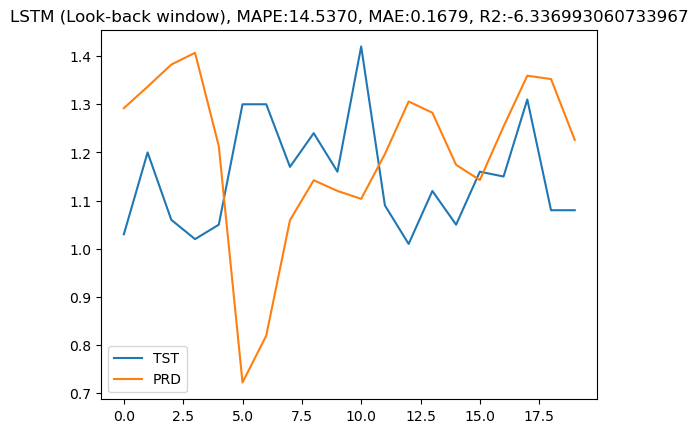

In [15]:
prd = scaler.inverse_transform(p.cpu())
# prd = p.cpu()

plt.title(f"LSTM (Look-back window), MAPE:{cal_mape(prd,tst.to_numpy()):.4f}, MAE:{cal_mae(prd,tst.to_numpy()):.4f}, R2:{cal_r2_score(prd,tst.to_numpy())}")
plt.plot(tst.to_numpy()[:,:1], label='TST')
plt.plot(prd, label='PRD')
plt.legend()
plt.show()

In [16]:
torch.save(rnn.state_dict(), './model/Adam(2, 32, 2, 2)0.0001,3000model.pth')